In [1]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import time as tm
import gsw as sw
from scipy.optimize import curve_fit


from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def convert_KM(sds):
    lon_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lon']
    lon_tmp = lon_tmp//100 + (lon_tmp - lon_tmp//100*100)/60
    lat_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lat']
    lat_tmp = lat_tmp//100 + (lat_tmp - lat_tmp//100*100)/60
    
    sds.loc[sds['cruise']=='KiloMoana_1','lon'] = -lon_tmp
    sds.loc[sds['cruise']=='KiloMoana_1','lat'] = lat_tmp
    
    lon_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lon']
    lon_tmp2 = lon_tmp2//100 + (lon_tmp2 - lon_tmp2//100*100)/60
    lat_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lat']
    lat_tmp2 = lat_tmp2//100 + (lat_tmp2 - lat_tmp2//100*100)/60
    
    sds.loc[sds['cruise']=='SCOPE_2','lon'] = -lon_tmp2
    sds.loc[sds['cruise']=='SCOPE_2','lat'] = lat_tmp2
    
    return sds

def checklon(data):
    cxx = (data['lon']).values # longitude

    # convert all longitude to longitude east
    cxx[cxx<0]= 360+cxx[cxx<0];
    data['lon_e'] = cxx
    cxbew = cxx
    cxbew[cxbew>180] = cxbew[cxbew>180]-360   
    data['lon'] = cxbew
    return data

def distance(data):
    cruise = pd.unique(data['cruise'])
    distances = pd.DataFrame()    
    for c in cruise:
        temp = pd.DataFrame()
        temp = data.loc[(data['cruise']==c), ['cruise','file_time','lon','lat']]
        
        # calculate distance in km between points
        temp['dx'] = np.insert(sw.distance(temp['lon'].values, temp['lat'].values, 0),0,0)/1000
        temp['x'] = np.cumsum(temp['dx'])
        
        if c == cruise[0]:
            distances = distances.append(temp)
        else:
            distances = pd.concat([distances, temp], axis=0)
        del temp
    data = pd.merge(left = data, right = distances, how='left', left_on=['cruise','file_time','lat','lon'], right_on=['cruise','file_time','lat','lon'])
    #return distances

    return data  

def tracks(data):
    seg = []
    start = 0
    n = 1
    for i in range(len(data)):
        if ((data['dx'][i] > 20) | (data['dx'][i] < 0.01)):
            seg.append([data['cruise'][i], start, i-1, sum(data['dx'][start:i-1])])# - data['x'][start])])
                                                         
            n += 1
            start = i+1
    
    segments = pd.DataFrame(seg, columns = ['cruise', 'start', 'end', 'length']) 
    segments = segments.loc[(segments['length'] >= 200)]
    segments = segments.loc[(segments['end'] > 0)]
    segments['number'] = range(1, len(segments)+1)
    segments = segments.set_index(['number'])
    return segments

def getscales(data, segments, var, var2, offset):
    scales = pd.DataFrame()
    seg_fft = pd.DataFrame()
    
    for i in range(1, len(segments)+1):
        a = segments['start'][i]
        b = segments['end'][i]
        
        tmp = data[a:b]
        segnumber = i
        cruise = segments['cruise'][i]
        aa = data['x'][a]
        bb = data['x'][b]
        
       
        tmp = interpdata(tmp, aa, bb, var)
        seglength = len(tmp)
       
        tmp1 = detrenddata(tmp, var2) 
            
        # start the decorrelation calculation here
        tmp2, tmp3 = fft_data(tmp1, var2, cruise, segnumber)
            # append the scale data for each segment to the scales dataframe
        
        if i == 1 :
            scales = scales.append(tmp2)
            seg_fft = seg_fft.append(tmp3)
        else:
            scales = pd.concat([scales, tmp2], axis=0)
            seg_fft = seg_fft.merge(tmp3, left_on='wavenumber', right_on='wavenumber', how='outer')

        del tmp2, tmp1, tmp3

            
    scales['number'] = range(len(scales))
    scales = scales.set_index(['number'])    
    return scales, seg_fft
        
        
def fft_data(detdata, var, cruise, segnumber):
    # initialize the dataframe for the scales
    scales = pd.DataFrame()
    seg_fft = pd.DataFrame()
   
    # set the length of the segments to look at
    ll = len(detdata) # length of decorrelation segment
    
    
    scales['lat'] = (detdata['lat'].values)[ll/2]
    scales['lon'] = (detdata['lon'].values)[ll/2]
    scales['depth_mid'] = (detdata['depth'].values)[ll/2]
    scales['dcoast_mean'] = np.nanmean(detdata['dcoast'].values)
    scales['dcoast_mid'] = (detdata['dcoast'].values)[ll/2]
    scales['depth_mean'] = np.nanmean(detdata['depth'].values)
    scales['cruise'] = cruise
    scales['segment #'] = segnumber
    print segnumber, ll, cruise, (detdata['lat'].values)[ll/2], (detdata['lon'].values)[ll/2], np.mean(detdata['dom_group'].values)
    
    
    freq = np.fft.fftfreq(ll, 1.0)
    seg_fft['wavenumber'] = freq
        
    for v in var:

        tmp = detdata[v]

        # initialize array for the results, needs to b 3 cols, length t
        data = tmp
        yf = np.fft.fft(data*np.hanning(len(data)))
                                         
        # append to the scales dataframe
        v2 = '%s_%d' % (v, segnumber)
       
        seg_fft[v2] = yf
        del yf
            
    return scales, seg_fft
        

def interpdata(track, aa, bb, var):
    # we went to create a new dataframe which has the interpolated data for each track for all variables, 
    # and a position.
    intdata = pd.DataFrame()
    # set the interpolation distance 
    n = 1 # 1km 
    begin = np.floor(track['x'][:1])
    intdata['x'] = np.arange(aa, bb, n)
 
    for v in var:
        intdata[v] = np.interp(intdata['x'].values,track['x'].values,track[v].values)
          
    return intdata
        
def detrenddata(track, var2):
    # take the interpolated data and remove the large scale trend, e.g. apply a high pass filter.
    detdata = pd.DataFrame()
    detdata['x'] = track['x']
    detdata['lon'] = track['lon']
    detdata['lat'] = track['lat']
    detdata['depth'] = track['depth']
    detdata['dcoast'] = track['dcoast']
    detdata['dom_group'] = track['dom_group']
    

    # First, design the Butterworth filter
    N  = 3    # Filter order
    cutoff = 250. # length scale for cutoff
    Wn = 1/cutoff # Cutoff wavelength, normalised to n
    B, A = signal.butter(N, Wn, 'low', output='ba')
    
    # Second, apply the filter to each of the variables
    
    for v in var2:
        detdata[v] = track[v] - signal.filtfilt(B,A, track[v])
    return detdata
    

def fftbin(fft, bins, bin_mid):
    
    y = 1/(np.abs(fft['wavenumber'].values))
    
    binned = pd.DataFrame()
    bin_count = np.zeros(len(bins)-1)
    binned['k_mid'] = bin_mid
    
    var = fft.columns
    for v in var:
        
        z = np.abs(fft[v].values) # bead attribute

        digitized = np.digitize(y, bins)
        bin_count = [np.shape(z[digitized == i])[0] for i in range(1, len(bins))]

        bin_means = [np.nanmean(z[digitized == i]) for i in range(1, len(bins))]
        bin_std = [np.nanstd(z[digitized == i]) for i in range(1, len(bins))]
        
        binned[v] = bin_means
        
        v1 = '%s_sd' % v
        binned[v1] = bin_std

    return binned   

def most_abundant(row):
    if row['pico'] > row['synecho'] and row['pico'] > row['picoeuk']: 
        return 1
    if row['synecho'] > row['pico'] and row['synecho'] > row['picoeuk']: 
        return 2
    if row['picoeuk'] > row['synecho'] and row['picoeuk'] > row['pico']: 
        return 3
    


In [3]:
# import mega dataset
filePath = '/Users/sclayton/Google Drive/seaflow_data/abun_sds_opp.csv'
data = pd.read_csv(filePath, sep=',')
print data.columns

filePath = r'/Users/sclayton/Google Drive/seaflow_data/sds_depth.csv'
depth = pd.read_csv(filePath)

filePath = r'/Users/sclayton/Google Drive/seaflow_data/sds_dist2coast.csv'
dcoast = pd.read_csv(filePath)


Index([u'Unnamed: 0', u'Unnamed: 0.1', u'tot_chl', u'cruise', u'file_time',
       u'Unnamed: 0.1', u'file_duration', u'lat', u'lon', u'conductivity',
       u'salinity', u'ocean_tmp', u'par', u'bulk_red', u'stream_pressure',
       u'flow_rate', u'event_rate', u'avg_chl', u'avg_pe', u'avg_fsc',
       u'density', u'lon_e', u'dx', u'x', u'sds_time', u'file_time_r',
       u'opp.evt', u'ts', u'beads', u'cocco', u'crypto', u'diatoms',
       u'file_time_r.1', u'lgdiatoms', u'pico', u'picoeuk', u'smdiatoms',
       u'synecho', u'unknown'],
      dtype='object')


In [4]:
# add density 
data['density'] = sw.rho(data['salinity'].values,data['ocean_tmp'].values,0)
data = checklon(data)

# only keep KM1304 data
data = data[(data['cruise']=='KiloMoana_1')]
               
# sort the dataframe so that it is in date/time order
data = pd.merge(data, depth, on=['cruise','file_time'], how='inner')
data = pd.merge(data, dcoast, on=['cruise','file_time'], how='inner')
data = data.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
data = data.reset_index(drop=True)

# now we have a dataframe with the total alongtrack distance for each cruise, 
# and the distance between points for each file.

clean = data[['cruise', 'file_time', 'lon', 'lon_e', 'lat', 'depth', 'dcoast', 'salinity', 'ocean_tmp', 'density', 'pico', 'synecho', 'picoeuk']]
clean['tot_chl'] = data['tot_chl']#/(data['file_duration']*data['opp.evt']*data['flow_rate'])
clean = clean.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
clean['dom_group']= clean.apply(most_abundant, axis =1)
clean = distance(clean)


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# split the data into continuous segments at least 200 km long with no gaps bigger than 20 km.
segments = tracks(clean)

# now do the length scale analysis
# interpolate the data, detrend it using the low pass filter, then find the decorrelation scales
# loop over each segment
var = ['lat', 'lon', 'tot_chl', 'ocean_tmp', 'salinity', 'density', 'synecho', 'pico', 'picoeuk','depth', 'dcoast', 'dom_group']
var2 = ['tot_chl', 'ocean_tmp', 'salinity', 'density', 'synecho', 'pico', 'picoeuk']

scales, seg_fft = getscales(clean, segments, var, var2, 200)
#seg_fft = seg_fft.sort(['wavenumber'], ascending=True)

1 296 KiloMoana_1 49.1307312456 -132.681922556 1.0
2 291 KiloMoana_1 49.4296402902 -136.667178658 1.0
3 299 KiloMoana_1 49.8436847619 -142.731487395 1.0
4 373 KiloMoana_1 49.9928315027 -147.390039472 1.30261090055
5 433 KiloMoana_1 48.0543939402 -149.999811521 2.4230982684
6 243 KiloMoana_1 42.7801217713 -150.000177164 1.45148417085
7 277 KiloMoana_1 40.2438169439 -149.999943769 1.00698359204
8 433 KiloMoana_1 36.9474431545 -150.000811491 1.00918229182
9 221 KiloMoana_1 34.0171686099 -150.000388899 1.0
10 246 KiloMoana_1 31.0993562676 -150.000207602 1.0
11 480 KiloMoana_1 28.4154072744 -151.595548217 1.0
12 410 KiloMoana_1 25.0429932592 -156.717397138 1.0


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:118: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:119: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:120: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:122: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:126: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
# try fitting explonential curves to the fft results

# print seg_fft.columns

# def fx(x):
#     return np.log10(np.abs(x))
# log_fft = seg_fft.apply(fx)
# print log_fft

def line(x, a, b):
    return b * x + a

var = seg_fft.columns[1::]

for i in var:
    x = np.abs(seg_fft['wavenumber'].values)
    y = np.abs(seg_fft[i].values)
    
    # need to remove rows with NaN of Inf from x and y
    x = np.log10(x[~np.isnan(y)])
    y = np.log10(y[~np.isnan(y)])
    
    y = y[~np.isinf(x)]
    x = x[~np.isinf(x)]
    
    popt, pcov = curve_fit(line, x, y)
    print i, ", slope = ", popt[1], "+/-", pcov[1,1]**0.5
    
    # save out the slopes to a dataframe...


tot_chl_1 , slope =  -1.03771561766 +/- 0.0388032023038
ocean_tmp_1 , slope =  -1.11395032643 +/- 0.0380407489607
salinity_1 , slope =  -1.33871861644 +/- 0.0360701894857
density_1 , slope =  -1.25086594997 +/- 0.0446667329439
synecho_1 , slope =  -1.15397455353 +/- 0.0360006443781
pico_1 , slope =  -0.742183891796 +/- 0.035585418972
picoeuk_1 , slope =  -0.911804024 +/- 0.0386541000887
tot_chl_2 , slope =  -0.779132105725 +/- 0.0377486240106
ocean_tmp_2 , slope =  -1.24230481825 +/- 0.0416849723498
salinity_2 , slope =  -1.35346696871 +/- 0.0352825287669
density_2 , slope =  -1.24074415878 +/- 0.0369212180708
synecho_2 , slope =  -0.773745814977 +/- 0.0401076533155
pico_2 , slope =  -0.51474048511 +/- 0.0425592703591
picoeuk_2 , slope =  -0.857056770302 +/- 0.0343932077261
tot_chl_3 , slope =  -0.695511520351 +/- 0.0400203344885
ocean_tmp_3 , slope =  -1.70032958062 +/- 0.0467950414644
salinity_3 , slope =  -1.69544546844 +/- 0.0398203961724
density_3 , slope =  -1.67050590369 +/- 0.0

In [8]:
# try averaging out the spectra...
# wavenumbers for bins
k_bins = 10 ** (0.1 * np.arange(31))
k_bin_mid = k_bins[:(len(k_bins)-1)] + np.diff(k_bins)/2

# ten bins per decade
# 10 ** (0.1 * np.arange(31))

binned = fftbin(seg_fft, k_bins, k_bin_mid)

bin_mean = pd.DataFrame()
bin_mean['k_mid'] = binned['k_mid']

add = np.zeros(len(binned))
#add[:] = np.NAN

for v in var2:
    tmp = pd.DataFrame()
    for n in range(4,7, 1):
        m = '%s_%d' % (v, n)
        tmp[m] = binned[m]
    
    sd = '%s_sd' % v
    bin_mean[v] = tmp.mean(axis = 1, skipna = True)
    bin_mean[sd] = tmp.std(axis = 1, skipna = True)


/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


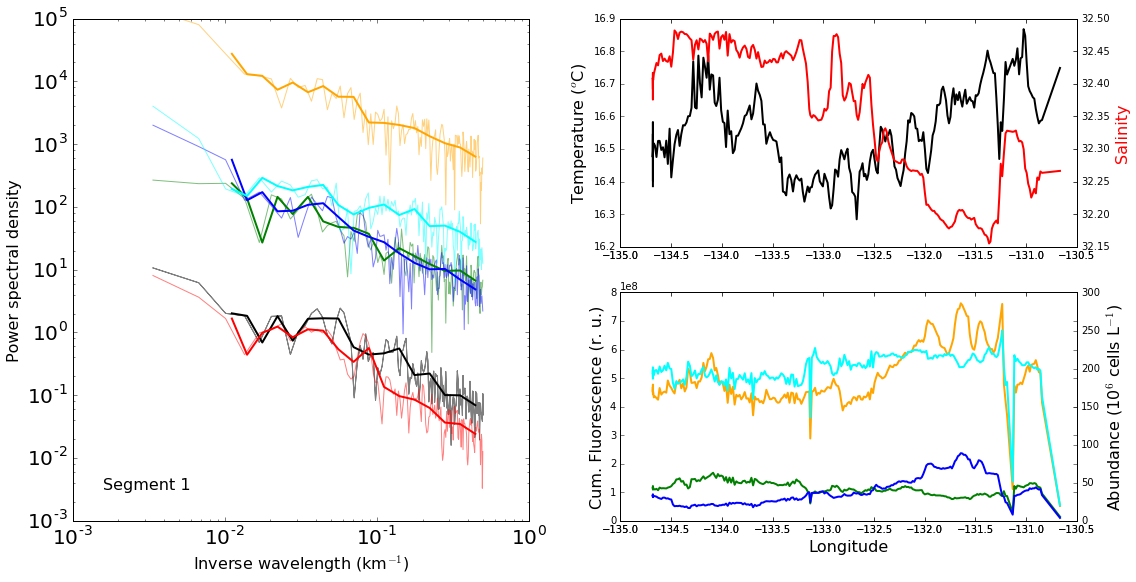

In [11]:
fig1 = plt.figure(1, figsize=(18, 9), dpi = 600)

sub1 = fig1.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 1', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_1']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_1']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_1']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_1']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_1']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_1']/100000), 'orange', alpha=0.5, label = 'fluorescence')

#sub1.loglog(seg_fft['wavenumber'],np.abs(-0.00034419383441 * seg_fft['wavenumber'] **-0.820518205024), 'k', lw = 4)

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_1']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_1']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_1']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_1']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_1']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_1']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][1]
b = segments['end'][1]

sub2 = fig1.add_subplot(222)
sub2.plot(clean['lon'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig1.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lon'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig1.add_subplot(224)
sub3.plot(clean['lon'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Longitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig1.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lon'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lon'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lon'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig1.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_1_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

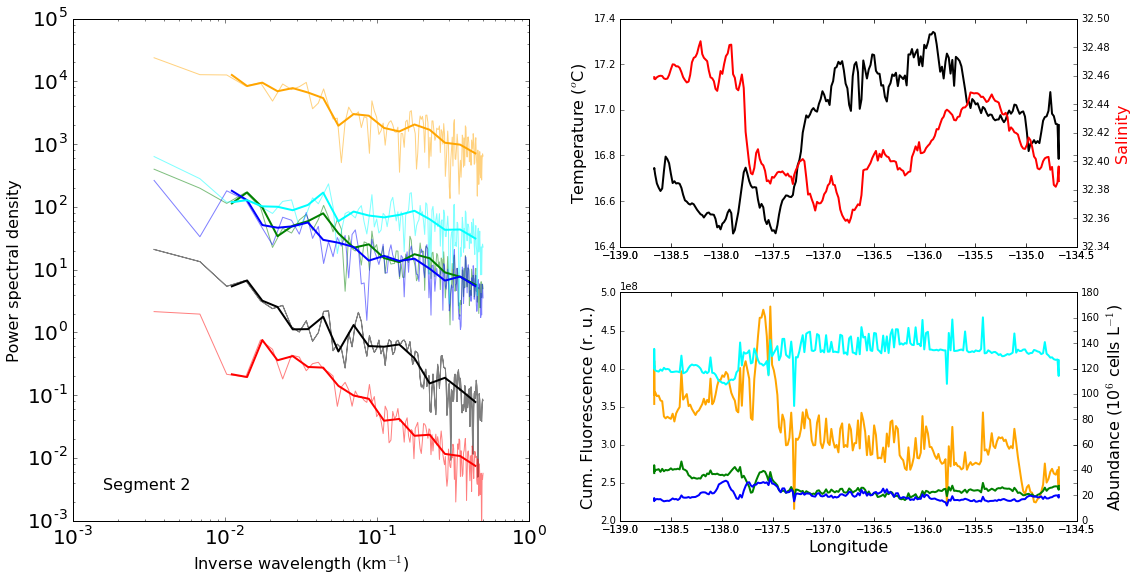

In [12]:
fig2 = plt.figure(2, figsize=(18, 9), dpi = 600)

sub1 = fig2.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 2', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_2']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_2']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_2']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_2']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_2']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_2']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_2']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_2']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_2']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_2']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_2']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_2']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][2]
b = segments['end'][2]

sub2 = fig2.add_subplot(222)
sub2.plot(clean['lon'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig2.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lon'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig2.add_subplot(224)
sub3.plot(clean['lon'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Longitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig2.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lon'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lon'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lon'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig2.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_2_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

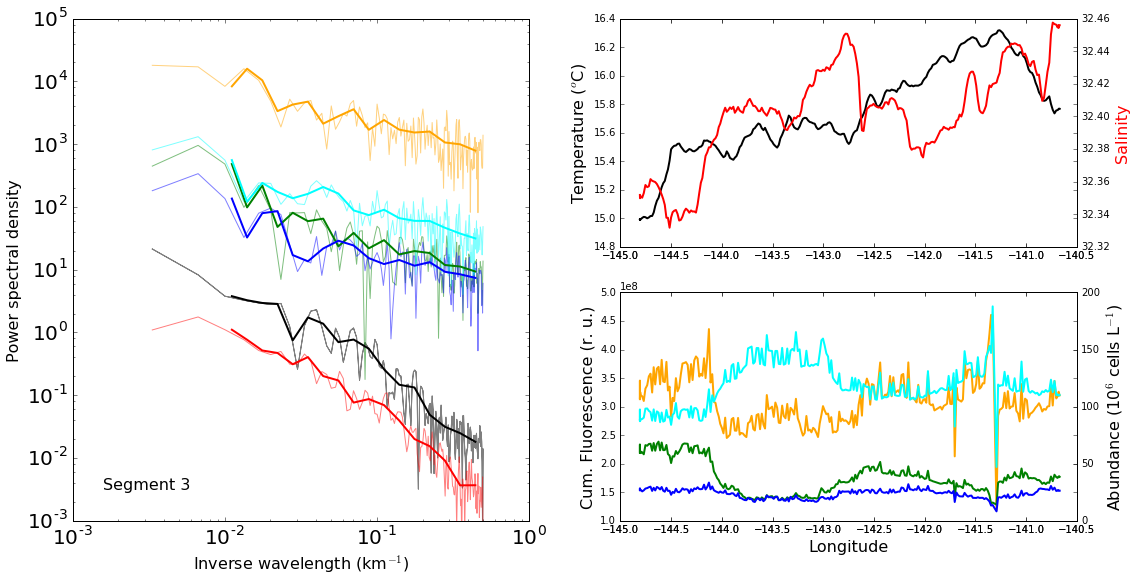

In [13]:
fig3 = plt.figure(3, figsize=(18, 9), dpi = 600)

sub1 = fig3.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 3', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_3']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_3']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_3']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_3']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_3']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_3']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_3']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_3']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_3']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_3']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_3']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_3']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][3]
b = segments['end'][3]

sub2 = fig3.add_subplot(222)
sub2.plot(clean['lon'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig3.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lon'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig3.add_subplot(224)
sub3.plot(clean['lon'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Longitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig3.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lon'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lon'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lon'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig3.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_3_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

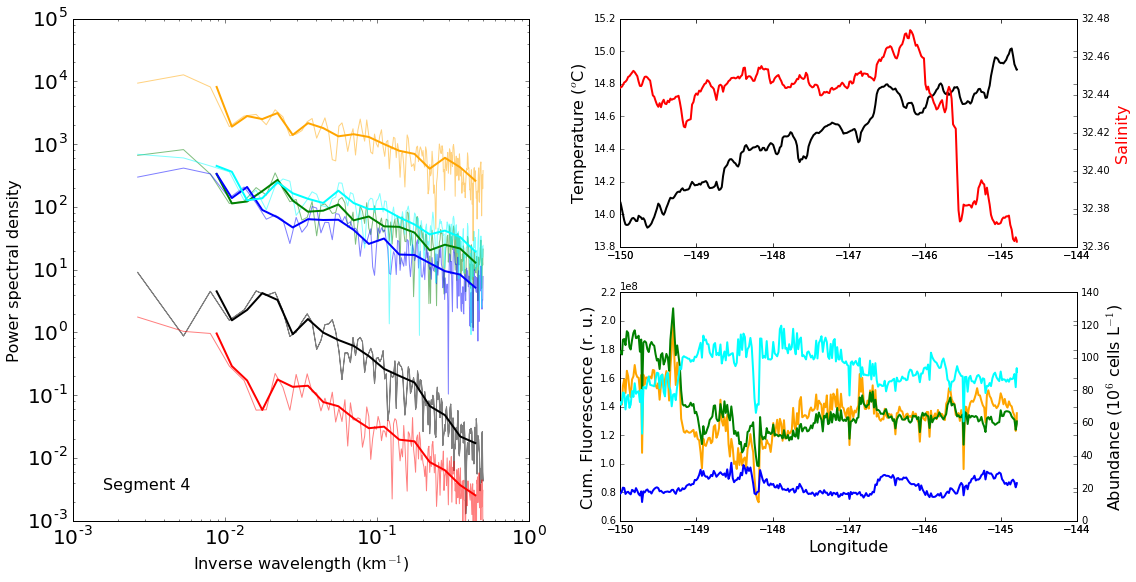

In [14]:
fig4 = plt.figure(4, figsize=(18, 9), dpi = 600)

sub1 = fig4.add_subplot(121)

sub1.text(10**-2.8, 10**-2.5, 'Segment 4', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_4']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_4']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_4']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_4']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_4']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_4']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_4']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_4']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_4']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_4']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_4']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_4']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][4]
b = segments['end'][4]

sub2 = fig4.add_subplot(222)
sub2.plot(clean['lon'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig4.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lon'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig4.add_subplot(224)
sub3.plot(clean['lon'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Longitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig4.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lon'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lon'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lon'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig4.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_4_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

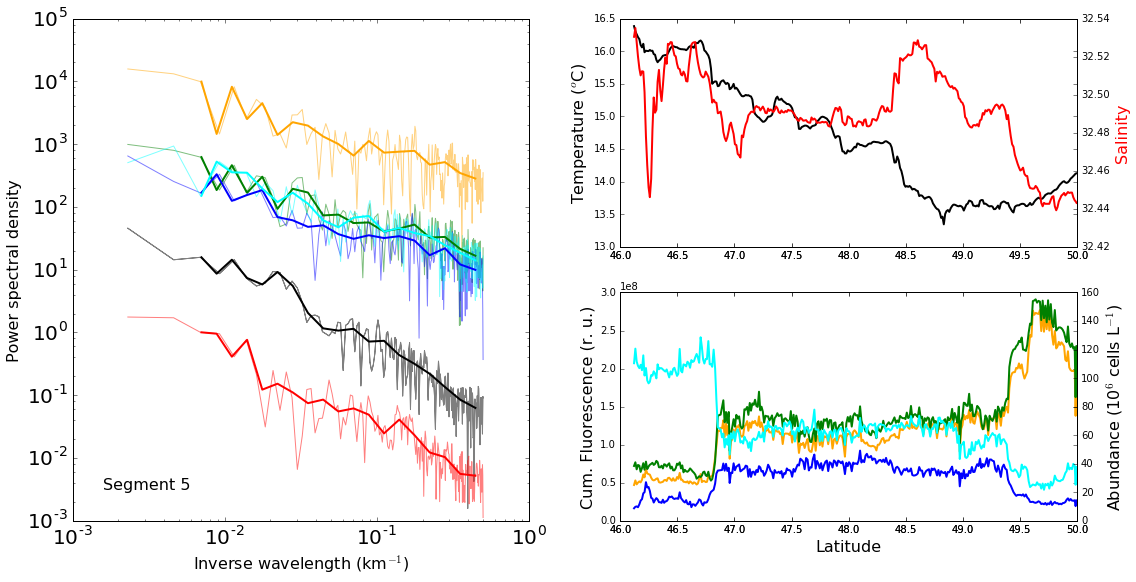

In [15]:
fig5 = plt.figure(5, figsize=(18, 9), dpi = 600)

sub1 = fig5.add_subplot(121)

sub1.text(10**-2.8, 10**-2.5, 'Segment 5', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_5']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_5']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_5']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_5']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_5']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_5']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_5']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_5']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_5']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_5']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_5']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_5']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][5]
b = segments['end'][5]

sub2 = fig5.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig5.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig5.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig5.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig1.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_5_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

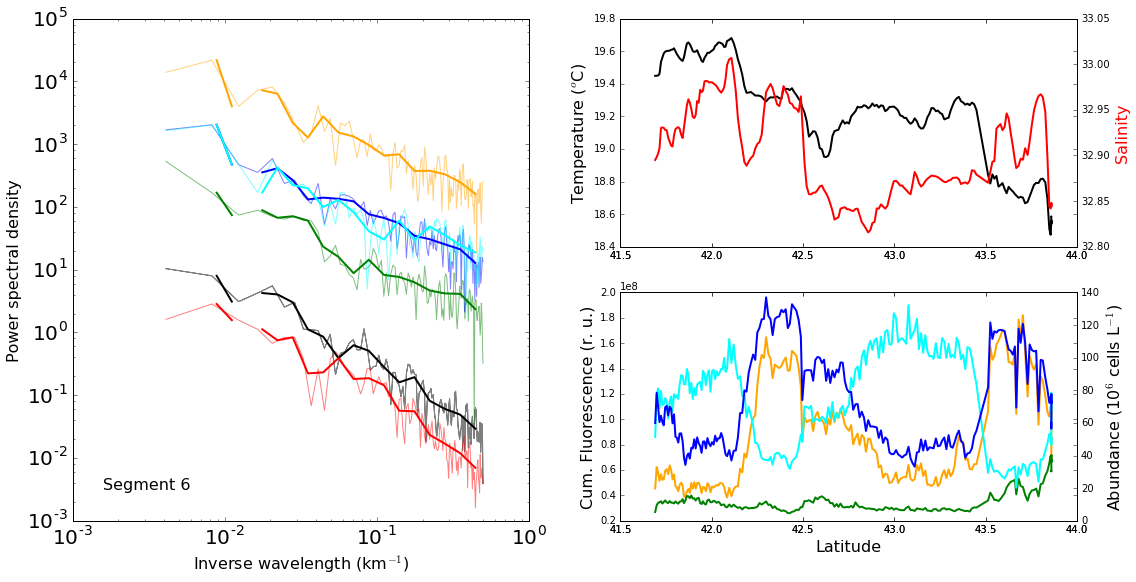

In [16]:
fig6 = plt.figure(6, figsize=(18, 9), dpi = 600)

sub1 = fig6.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 6', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_6']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_6']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_6']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_6']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_6']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_6']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_6']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_6']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_6']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_6']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_6']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_6']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][6]
b = segments['end'][6]

sub2 = fig6.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig6.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig6.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig6.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig6.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_6_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

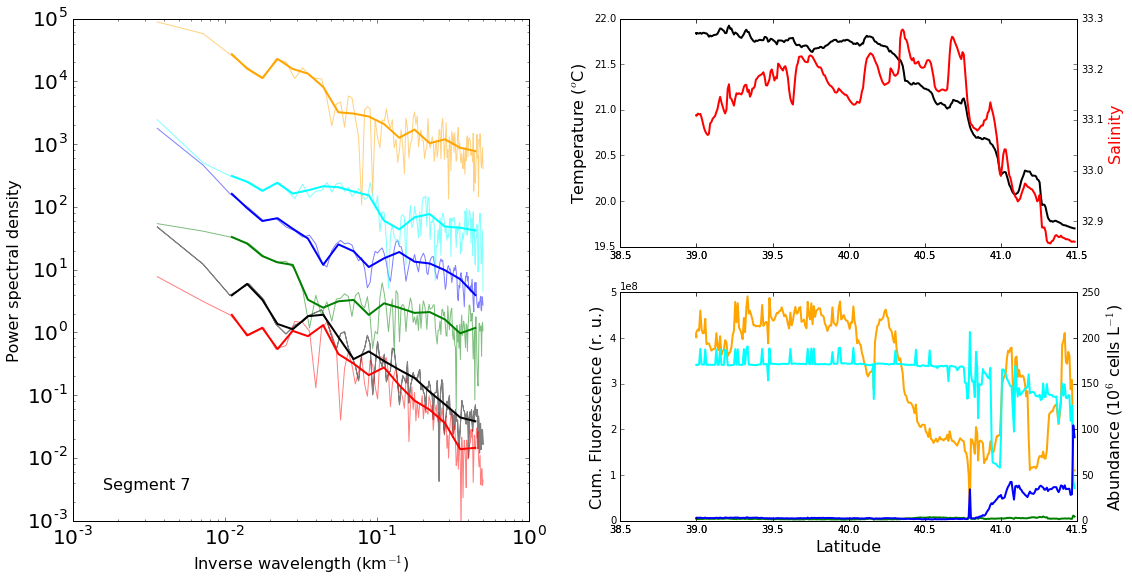

In [17]:
fig7 = plt.figure(7, figsize=(18, 9), dpi = 600)

sub1 = fig7.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 7', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_7']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_7']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_7']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_7']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_7']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_7']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_7']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_7']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_7']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_7']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_7']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_7']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][7]
b = segments['end'][7]

sub2 = fig7.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig7.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig7.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig7.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig7.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_7_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

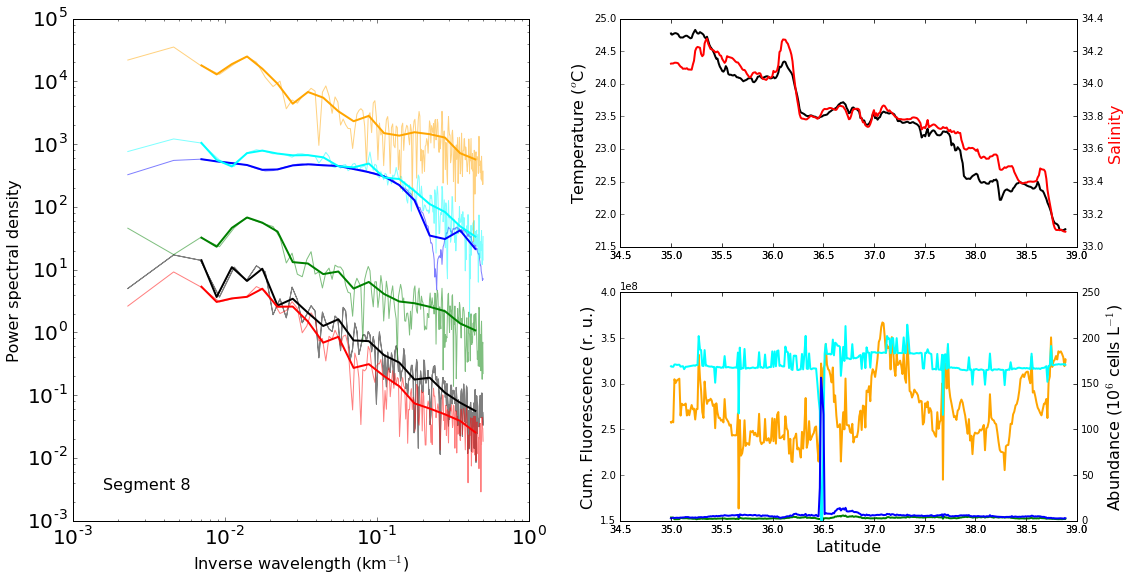

In [18]:
fig8 = plt.figure(8, figsize=(18, 9), dpi = 600)

sub1 = fig8.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 8', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_8']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_8']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_8']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_8']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_8']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_8']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_8']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_8']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_8']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_8']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_8']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_8']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][8]
b = segments['end'][8]

sub2 = fig8.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig8.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig8.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig8.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig8.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_8_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

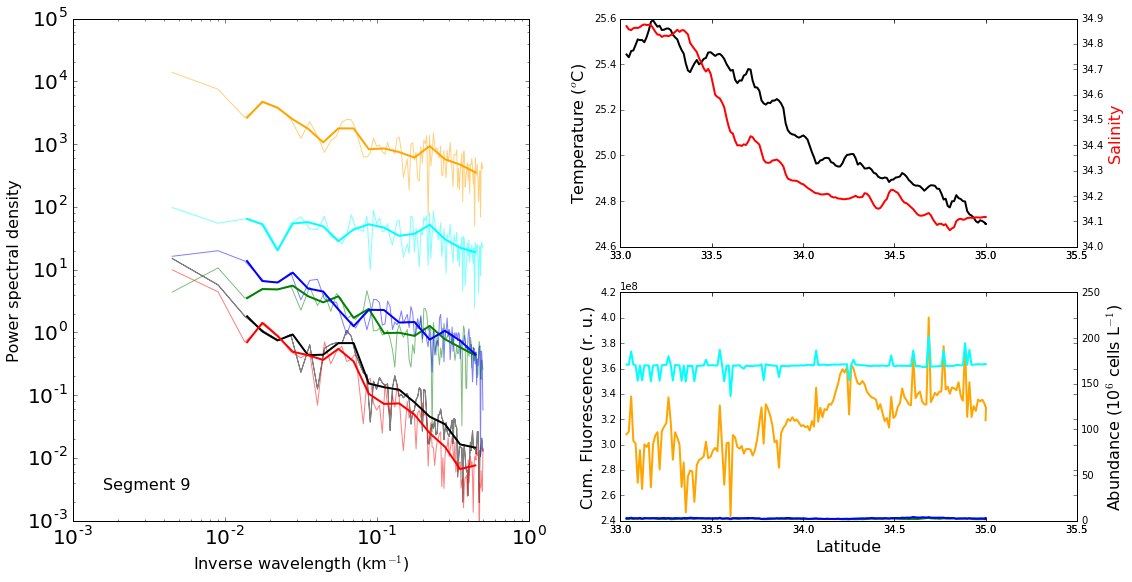

In [19]:
fig9 = plt.figure(9, figsize=(18, 9), dpi = 600)

sub1 = fig9.add_subplot(121)

sub1.text(10**-2.8, 10**-2.5, 'Segment 9', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_9']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_9']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_9']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_9']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_9']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_9']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_9']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_9']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_9']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_9']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_9']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_9']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][9]
b = segments['end'][9]

sub2 = fig9.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig9.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig9.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig9.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig9.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_9_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

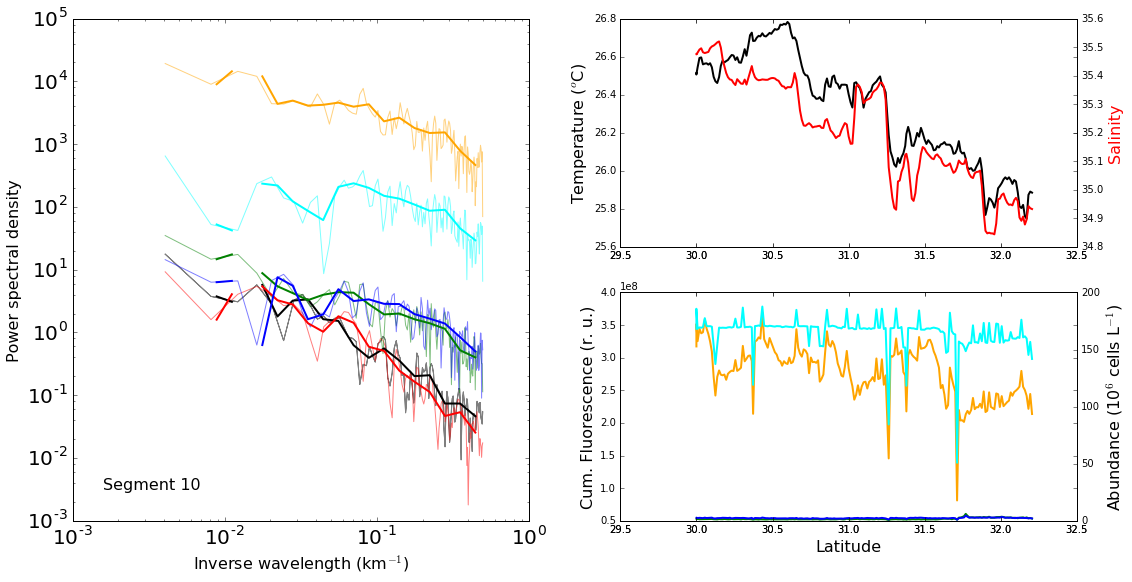

In [20]:
fig10 = plt.figure(10, figsize=(18, 9), dpi = 600)

sub1 = fig10.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 10', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_10']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_10']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_10']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_10']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_10']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_10']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_10']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_10']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_10']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_10']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_10']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_10']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][10]
b = segments['end'][10]

sub2 = fig10.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig10.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig10.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig10.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig10.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_10_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

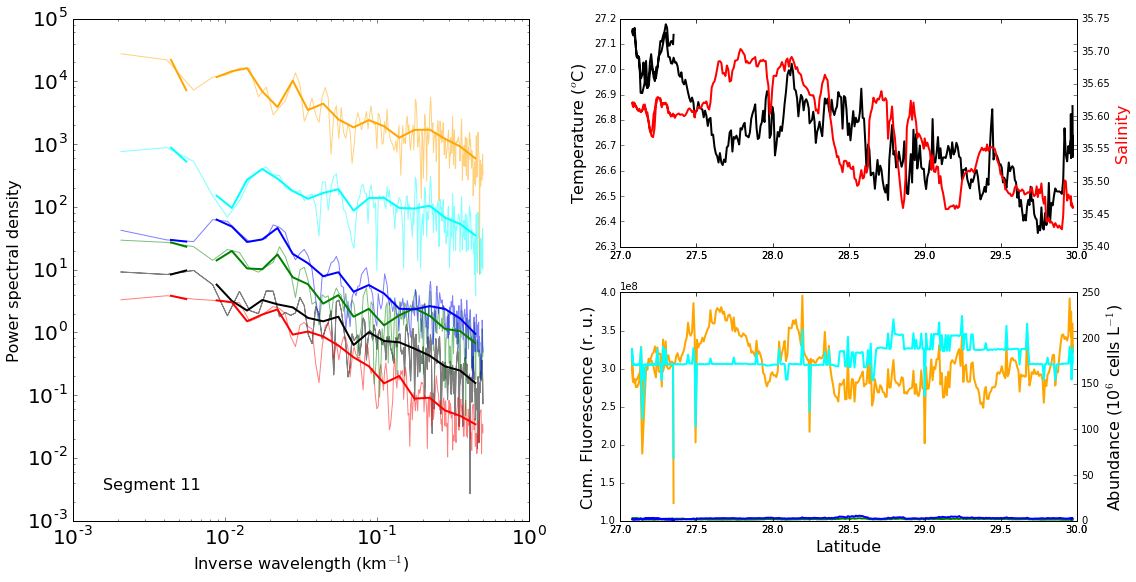

In [21]:
fig11 = plt.figure(11, figsize=(18, 9), dpi = 600)

sub1 = fig11.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 11', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_11']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_11']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_11']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_11']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_11']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_11']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_11']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_11']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_11']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_11']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_11']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_11']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][11]
b = segments['end'][11]

sub2 = fig11.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig11.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig11.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig11.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)


plt.show()
fig11.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_11_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl

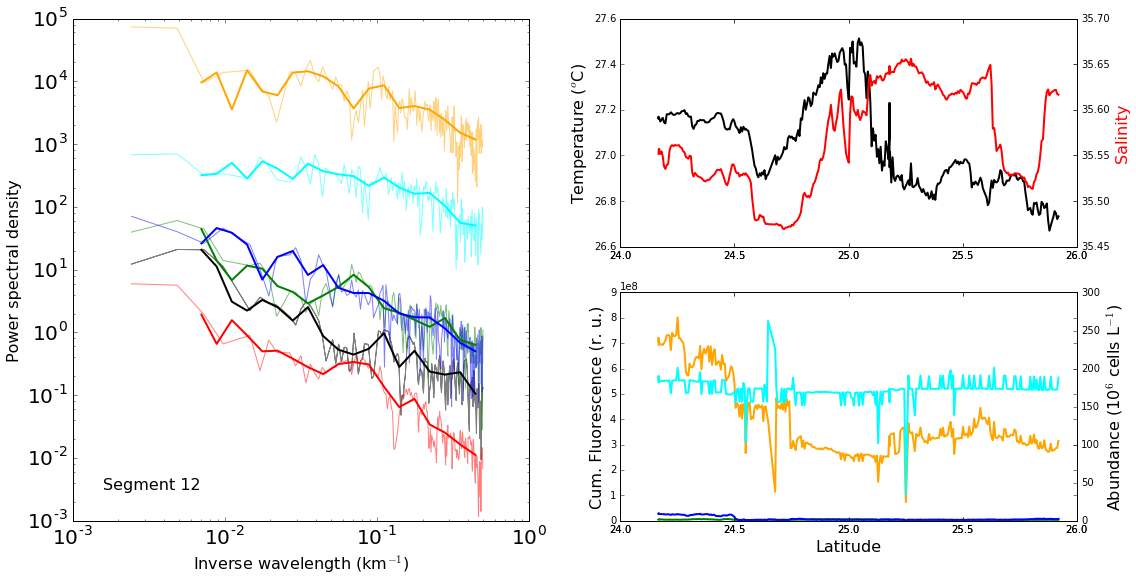

In [23]:
fig12 = plt.figure(12, figsize=(18, 9), dpi = 600)

sub1 = fig12.add_subplot(121) 

sub1.text(10**-2.8, 10**-2.5, 'Segment 12', fontsize = 16)
sub1.set_xlim([10**-3, 1])
sub1.set_ylim([10**-3, 10**5])

sub1.loglog(np.abs(seg_fft['wavenumber']), np.abs(seg_fft['ocean_tmp_12']), 'k', alpha=0.5, label='temperature')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['salinity_12']), 'r', alpha=0.5, label = 'salinity')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['picoeuk_12']), 'g', alpha=0.5, label = 'picoeuks')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['synecho_12']), 'b', alpha=0.5, label = 'synechococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['pico_12']), 'cyan', alpha=0.5, label = 'prochlorococcus')
sub1.loglog(seg_fft['wavenumber'], np.abs(seg_fft['tot_chl_12']/100000), 'orange', alpha=0.5, label = 'fluorescence')

sub1.loglog(1./binned['k_mid'], np.abs(binned['ocean_tmp_12']), 'k', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['salinity_12']), 'r', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['picoeuk_12']), 'g', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['synecho_12']), 'b', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['pico_12']), 'cyan', lw=2)
sub1.loglog(1./binned['k_mid'], np.abs(binned['tot_chl_12']/100000), 'orange', lw=2)

sub1.tick_params(axis='both', which='major', labelsize=20)
sub1.tick_params(axis='both', which='minor', labelsize=20)
sub1.set_xlabel('Inverse wavelength (km$^{-1}$)', fontsize = 16)
sub1.set_ylabel('Power spectral density', fontsize = 16)
#sub1.legend()

# find beginning/end of segment
a = segments['start'][12]
b = segments['end'][12]

sub2 = fig12.add_subplot(222)
sub2.plot(clean['lat'][a:b],clean['ocean_tmp'][a:b], 'k', lw=2 )
sub2.set_ylabel('Temperature ($^o$C)', fontsize = 16)

ax2 = fig12.add_subplot(222, sharex=sub2, frameon=False)
ax2.plot(clean['lat'][a:b],clean['salinity'][a:b], 'r' , lw=2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Salinity', color = 'r', fontsize = 16)

sub3 = fig12.add_subplot(224)
sub3.plot(clean['lat'][a:b],clean['tot_chl'][a:b], 'orange' , lw=2)
sub3.set_xlabel('Latitude', fontsize = 16)
sub3.set_ylabel('Cum. Fluorescence (r. u.)', fontsize = 16)

ax3 = fig12.add_subplot(224, sharex=sub3, frameon=False)
ax3.plot(clean['lat'][a:b],clean['picoeuk'][a:b], 'g' , lw=2)
ax3.plot(clean['lat'][a:b],clean['pico'][a:b], 'cyan' , lw=2)
ax3.plot(clean['lat'][a:b],clean['synecho'][a:b], 'b' , lw=2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Abundance (10$^6$ cells L$^{-1}$)', color = 'k', fontsize = 16)

plt.show()
fig12.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/KM1304_12_spectra.png', bbox_inches='tight', dpi=600)

# green = picoeuk
# cyan = pro*
# blue = synecho*
# red = salinity
# black = temp
# orange = chl